In [1]:
import numpy as np
import lal
from scipy.interpolate import interp1d
from gwpy.timeseries import TimeSeries
import qnm
from pylab import *

import arviz as az
import pandas as pd
import seaborn as sns
import bilby

import ringdown

sns.set_context('notebook')
sns.set_palette('colorblind')

In [39]:
mag_from_nr=np.array([  0.13657646 +0.95055905j,   3.14657959 -2.71266413j,
       -10.84170677 +3.607406j  ,  22.67958241 -8.01885436j,
       -30.44795174+19.91714543j,  22.09429848-26.19835642j,
        -7.43071591+15.89029183j,   1.0005728  -3.63046079j])

In [40]:
abs(mag_from_nr)

array([ 0.96032059,  4.15445662, 11.42610974, 24.05546681,
       36.38365632, 34.27115266, 17.54186174,  3.76581883])

In [2]:
def planck_window(t, tMin=0., tMax=1., tol=.005, rolloff=False):
    """
A smooth function f mapping [tMin, tMax] to [0, 1], with
f(tMin)=0, f(tMax)=1, all derivatives -> 0 as t->0 or t->tMax.
f(t) = 1/(1 + exp(z)) where z = 1/t - 1/(1-t) for the case
tMin=0, tMax=1.
tol controls the minimum deviation of t from 0 or tMax, with
a tol of .005 giving abs(z) < ~200, where exp(z) is 1.e86 or 1.e-86

If rolloff, instead has f(0)=1, f(tMax)=0.
    """
    if rolloff:
        return helper.planck_window(-t, tMin=-tMax, tMax=-tMin, tol=tol)

    if tMax==1. and tMin==0.:
        # If t <= .005, z >= 200. - 1./199. and exp(z) > 1.e86 ~ infinity
        # Similar for t > .995 but exp(z) < 1.e-86 ~ 0
        safe = (t>tol)*(t<(1.-tol))
        safeT = safe*t + (1. - safe)*.5 # use t = 0.5 temporarily for unsafe values
        safeZ = 1./safeT - 1./(1. - safeT)
        return safe*1./(1. + np.exp(safeZ)) + (t >= (1.-tol))

    return planck_window((t-tMin)/(tMax-tMin))

In [14]:
def load_data(iota,beta,t_unit):
    h2m2=np.loadtxt('Y_l2_m-2.dat')
    h22=np.loadtxt('Y_l2_m2.dat')
    time=h22[:,0]-3692.7480095302817

    h2=(h22[:,1]+1j*h22[:,2])*lal.SpinWeightedSphericalHarmonic(iota,beta,-2,2,2)\
    +(h2m2[:,1]+1j*h2m2[:,2])*lal.SpinWeightedSphericalHarmonic(iota,beta,-2,2,-2)
#     h2=(h22[:,1]+1j*h22[:,2])
    ts=np.arange(time[0]+50,time[-1],0.1)
    dtcut=ts[1]-ts[0]
    h2int=interp1d(time,h2)(ts)
    partition=2
    padlen=2**(3+int(np.ceil(np.log2(len(h2int)))))-len(h2int)
    ini_filter=planck_window(ts, tMin=ts[0], tMax=ts[0]+400)
    h2pad=np.pad(h2int*ini_filter,(padlen//partition,padlen-(padlen//partition)),'constant', constant_values=(0, 0))
    end1=ts[-1]+(padlen-(padlen//partition))*dtcut
    end2=ts[0]-(padlen//partition)*dtcut

    tpad=np.pad(ts,(padlen//partition,padlen-(padlen//partition)),'linear_ramp', end_values=(end2, end1))
#     tpad-=tpad[0]
    return tpad*t_unit,(h2pad)

In [15]:
def fac(ffreq,l,m,n,chi=0.692085186818):
    ome=qnm.modes_cache(s=-2,l=l,m=m,n=n)(a=chi)[0]
#     return -1j*(ffreq-ome)
    return (ffreq-ome)/(ffreq-np.conj(ome))*(ffreq+np.conj(ome))/(ffreq+ome)

In [16]:
def decayplot(t,l,m,n):
    ome=qnm.modes_cache(s=-2,l=l,m=m,n=n)(a=0.692085186818)[0]/(Mf*t_unit)
    return [t[t>-0.01],np.exp(-1j*ome*t)[t>-0.01]]

In [17]:
def NR_injection_into_Bilby(time,tpad,h2pad,M_tot,solar_to_distance,dis, **waveform_kwargs):
    hplus_interp_func = interp1d(tpad, np.real(h2pad), bounds_error=False, fill_value=0)
    hcross_interp_func = interp1d(tpad, -np.imag(h2pad), bounds_error=False, fill_value=0)
    hplus = hplus_interp_func(time)/dis#*M_tot*solar_to_distance
    hcross = hcross_interp_func(time)/dis#*M_tot*solar_to_distance
    return {'plus': hplus, 'cross': hcross}

In [18]:
Mf=0.952032939704
chi=0.692085186818
M_est_total=65/Mf

In [163]:
def inject_gau(distance,M_tot):

    solar_to_distance=2950./2
    solar_to_time=2950./2/299792458
    t_unit=M_tot*solar_to_time
    Mpc=30860000000000004*1000104.4887813144596
    dis=distance
    

    duration = 4
    sampling_frequency = 2048.*4

    
    iota=np.pi/3
    beta=np.pi/3*0

    tpad,h2pad=load_data(iota,beta,t_unit)
    
    tfinal=np.arange(-duration/2,duration/2,1./sampling_frequency)
    h_int=NR_injection_into_Bilby(tfinal,tpad,h2pad,M_tot,solar_to_distance,dis)
    
    rng = np.random.default_rng(12345)
    signal=h_int['plus']+ rng.normal(0, 1, len(tfinal))

    
    fpsi422=np.fft.rfft(h_int['plus'],norm='ortho')
    ffreq=np.fft.rfftfreq(len(signal),d=(tfinal[1]-tfinal[0])/(Mf*t_unit))*2*np.pi
    return tfinal,signal,ffreq,fpsi422,t_unit

In [292]:
tfinal,signal,ffreq,fpsi422,t_unit=inject_gau(distance=0.06,M_tot=M_est_total)

In [323]:
cond_data=np.fft.irfft(fac(-ffreq,2,2,0)*fpsi422,norm='ortho',n=len(signal))
cond_data=np.fft.irfft(fpsi422,norm='ortho',n=len(signal))

In [324]:
h_raw_strain =ringdown.Data(signal, index=tfinal)
signal_filter=ringdown.Data(cond_data, index=tfinal)

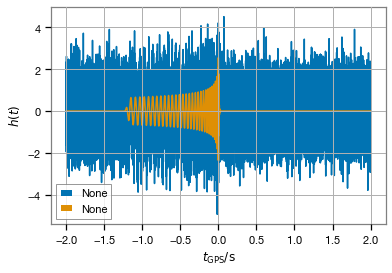

In [349]:
h_raw_strain.plot(label=h_raw_strain.ifo)
signal_filter.plot()
# l_raw_strain.plot(label=l_raw_strain.ifo)
xlabel(r'$t_\mathrm{GPS} / \mathrm{s}$');
ylabel(r'$h(t)$');
legend(loc='best');
savefig('res/nr_injection_waveform_d006.pdf',bbox_inches='tight')

In [350]:
acf = ringdown.AutoCovariance(zeros_like(h_raw_strain), delta_t=h_raw_strain.delta_t)
acf.iloc[0] = 1

In [351]:
chi_filter=chi
mass_filter=1.

In [352]:
fit = ringdown.Fit(model='mchi_aligned_ftau', modes=[(1, -2, 2, 2, 0),(1, -2, 2, 2, 1)])

fit.add_data(h_raw_strain, acf=acf)
# fit.filter_data(chi_filter,M_est_total*Mf*mass_filter,0)

t0=0*t_unit
T = (100)*t_unit-t0
T = 0.015
fit.set_target(t0, duration=T)

In [353]:
# fit.condition_data(ds=int(1), flow=30)

(0.0, 0.015)

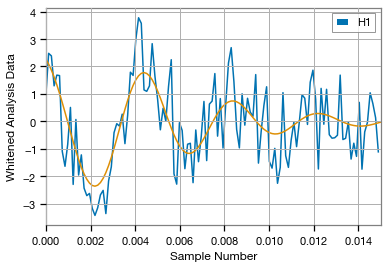

In [358]:
wd = fit.analysis_data
plot(wd[None], label='H1')
plot(tfinal,((cond_data)))
legend(loc='best');
xlabel(r'Sample Number');
ylabel(r'Whitened Analysis Data');
xlim(t0,t0+T)

In [359]:
fit.start_times

{None: 0.0}

In [360]:
print(fit.valid_model_options)

['A_scale', 'M_min', 'M_max', 'chi_min', 'chi_max', 'flat_A']


In [361]:
fit.update_prior(A_scale=50, M_min=25.0, M_max=140.0, flat_A=True)
fit.prior_settings

{'A_scale': 50,
 'M_min': 25.0,
 'M_max': 140.0,
 'chi_min': 0,
 'chi_max': 0.99,
 'flat_A': True}

In [362]:
fit.run(target_accept=0.96,tune=2000)

In [363]:
# hdi: highest density interval
# mcse: Monte Carlo standard error
# ess bulk effective sample size 
# r_hat: The `potential scale reduction factor' (PSRF) 
#    is an estimated factor by which the scale of the current distribution for 
#    the target distribution might be reduced if the simulations were continued for 
#     an infinite number of iterations. Each PSRF declines to 1 as the number of iterations approaches infinity.
az.summary(fit.result, var_names=['A','phi', 'M', 'chi'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
A[0],7.435,1.027,5.692,9.527,0.025,0.018,1630.0,1224.0,1.0
A[1],9.121,2.262,5.295,13.687,0.055,0.040,1683.0,1321.0,1.0
phi[0],0.685,0.221,0.230,1.054,0.006,0.004,1553.0,1325.0,1.0
phi[1],-1.961,0.316,-2.445,-1.523,0.008,0.006,1550.0,1418.0,1.0
M,65.880,5.899,54.960,76.946,0.198,0.140,862.0,828.0,1.0
chi,0.624,0.133,0.366,0.851,0.005,0.004,780.0,639.0,1.0


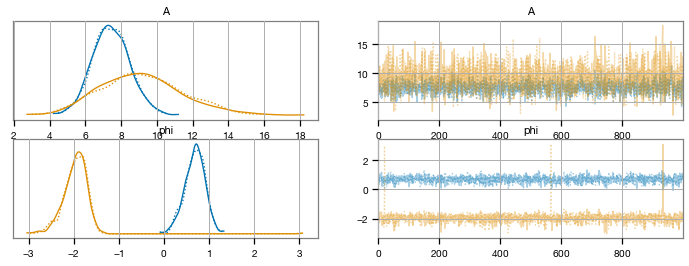

In [364]:
az.plot_trace(fit.result, var_names=['A', 'phi'], compact=True);

In [365]:
Mass_0ne_sigma=quantile(fit.result.posterior.M.values.flatten(),[0.16,1-0.16])
Spin_0ne_sigma=quantile(fit.result.posterior.chi.values.flatten(),[0.16,1-0.16])

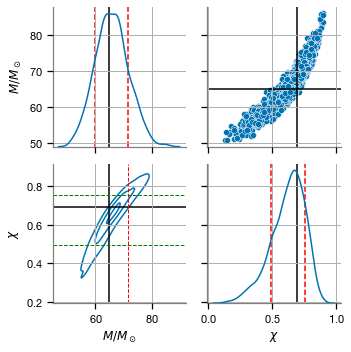

In [366]:
mIMR = M_est_total*Mf
chiIMR = chi

df = pd.DataFrame({
    r'$M / M_\odot$': fit.result.posterior.M.values.flatten(),
    r'$\chi$': fit.result.posterior.chi.values.flatten()
})
pg = sns.PairGrid(df, diag_sharey=False)
pg.map_diag(sns.kdeplot);
pg.map_upper(sns.scatterplot);
pg.map_lower(ringdown.kdeplot_2d_clevels, levels=[0.9, 0.5, 0.1])

pg.axes[0,0].axvline(mIMR, color='k')
pg.axes[0,0].axvline(Mass_0ne_sigma[0], ls='--', color='r')
pg.axes[0,0].axvline(Mass_0ne_sigma[1], ls='--', color='r')
pg.axes[0,1].axvline(chiIMR, color='k')
pg.axes[0,1].axhline(mIMR, color='k')
pg.axes[1,0].axhline(chiIMR, color='k')
pg.axes[1,0].axvline(mIMR, color='k')

pg.axes[1,0].axvline(Mass_0ne_sigma[0], ls='--', color='r',lw=1)
pg.axes[1,0].axvline(Mass_0ne_sigma[1], ls='--', color='r',lw=1)
pg.axes[1,0].axhline(Spin_0ne_sigma[0], ls='--', color='g',lw=1)
pg.axes[1,0].axhline(Spin_0ne_sigma[1], ls='--', color='g',lw=1)

pg.axes[1,1].axvline(chiIMR, color='k')
pg.axes[1,1].axvline(Spin_0ne_sigma[0], ls='--', color='r')
pg.axes[1,1].axvline(Spin_0ne_sigma[1], ls='--', color='r')
pg.savefig('res/nr_injection_no_filter.pdf')

In [367]:
import os
os.system('say "hi"')

0

# Reconstructions

In [373]:

# median reconstruction and 90%-credible envelope
wfs = [quantile(fit.result.posterior.h_det.values, q, axis=(0,1))[0,:]
       for q in [0.5, 0.95, 0.05]]
wfs = [ringdown.Data(wf, index=fit.result.constant_data.times[0,:]) for wf in wfs]

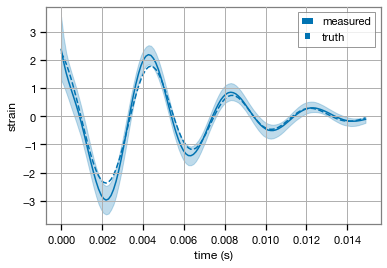

In [374]:

# plot reconstructions computed above
m, u, d = wfs
l, = plot(m, label='measured')
fill_between(m.time, u, d, color=l.get_color(), alpha=0.25)

# plot truth (using time mask to select right times)
plot(signal_filter[m.time], c=l.get_color(), ls='--', label='truth')
# xlim(0,0.02)
xlabel('time (s)')
ylabel('strain')
legend();
savefig('res/reconstruct_nr_injection_no_filter.pdf')

In [375]:
snrs_mf = fit.compute_posterior_snrs(optimal=False)

In [376]:
injsnr_mf = dot(signal_filter[m.time], wd[None][m.time]) / linalg.norm(signal_filter[m.time])

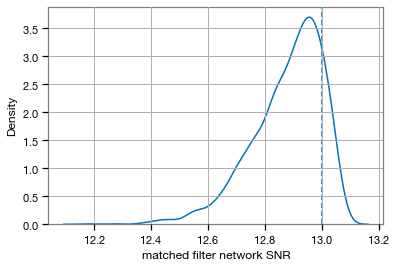

In [377]:
sns.kdeplot(snrs_mf)
axvline(injsnr_mf, ls='--');
xlabel('matched filter network SNR');
savefig('res/snr_no_injection_no_filter.pdf')